# Active Brownian Particles Simulation

This notebook demonstrates a simulation of active Brownian particles - particles that move with constant speed in a self-propelled manner while experiencing random rotational diffusion.

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython.display import HTML

In [110]:
class ActiveBrownianParticle:
    def __init__(self, x, y, angle, v0, dr):
        self.x = x
        self.y = y
        self.angle = angle
        self.v0 = v0
        self.dr = dr
        self.fx = 0
        self.fy = 0
    
    def calculate_forces(self, particles, passive_particles, box_size, k_repel=1.0, r_cutoff=1.0):
        self.fx = 0
        self.fy = 0
        
        for other in particles:
            if other is self:
                continue
            dx = other.x - self.x
            dy = other.y - self.y
            
            r = np.sqrt(dx**2 + dy**2)
            if 0 < r < r_cutoff:
                fx_pair = -k_repel * dx / r
                fy_pair = -k_repel * dy / r
                self.fx += fx_pair
                self.fy += fy_pair
        
        for passive in passive_particles:
            dx = passive.x - self.x
            dy = passive.y - self.y
            
            r = np.sqrt(dx**2 + dy**2)
            if 0 < r < r_cutoff:
                fx_pair = -k_repel * dx / r
                fy_pair = -k_repel * dy / r
                self.fx += fx_pair
                self.fy += fy_pair
    
    def update(self, dt, box_size):
        dangle = np.sqrt(2 * self.dr * dt) * np.random.normal()
        self.angle += dangle
        
        vx = self.v0 * np.cos(self.angle)
        vy = self.v0 * np.sin(self.angle)
        
        vx += self.fx * dt
        vy += self.fy * dt
        
        self.x += vx * dt
        self.y += vy * dt


class PassiveParticle:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.fx = 0
        self.fy = 0
    
    def calculate_forces(self, particles, passive_particles, box_size, k_repel=1.0, r_cutoff=1.0):
        self.fx = 0
        self.fy = 0
        
        for active in particles:
            dx = active.x - self.x
            dy = active.y - self.y
            
            r = np.sqrt(dx**2 + dy**2)
            if 0 < r < r_cutoff:
                fx_pair = -k_repel * dx / r
                fy_pair = -k_repel * dy / r
                self.fx += fx_pair
                self.fy += fy_pair
        
        for other in passive_particles:
            if other is self:
                continue
            dx = other.x - self.x
            dy = other.y - self.y
            
            r = np.sqrt(dx**2 + dy**2)
            if 0 < r < r_cutoff:
                fx_pair = -k_repel * dx / r
                fy_pair = -k_repel * dy / r
                self.fx += fx_pair
                self.fy += fy_pair
    
    def update(self, dt, box_size):
        vx = self.fx * dt
        vy = self.fy * dt
        
        vx += np.sqrt(0.1) * np.random.normal()
        vy += np.sqrt(0.1) * np.random.normal()
        
        self.x += vx * dt
        self.y += vy * dt

In [111]:
n_particles = 1000
box_size = 0.5
v0 = 0.2
dr = 0.1
dt = 0.05
n_steps = 10
k_repel = 0.1
r_cutoff = 0.1

active_particles = [
    ActiveBrownianParticle(
        x=np.random.uniform(box_size/2, box_size),
        y=np.random.uniform(0, box_size),
        angle=np.random.uniform(0, 2*np.pi),
        v0=v0,
        dr=dr
    )
    for _ in range(n_particles)
]

#passive particles
passive_particles = [
    PassiveParticle(
        x=np.random.uniform(0, box_size/2),
        y=np.random.uniform(0, box_size)
    )
    for _ in range(n_particles)
]


In [112]:
active_positions_history = []
passive_positions_history = []

for step in range(n_steps):
    for particle in active_particles:
        particle.calculate_forces(active_particles, passive_particles, box_size, k_repel, r_cutoff)
    
    for particle in passive_particles:
        particle.calculate_forces(active_particles, passive_particles, box_size, k_repel, r_cutoff)
    
    active_positions = []
    for particle in active_particles:
        particle.update(dt, box_size)
        active_positions.append((particle.x, particle.y))
    active_positions_history.append(active_positions)
    
    passive_positions = []
    for particle in passive_particles:
        particle.update(dt, box_size)
        passive_positions.append((particle.x, particle.y))
    passive_positions_history.append(passive_positions)
    
    print(f"Step {step + 1}/{n_steps} completed")


Step 1/10 completed
Step 2/10 completed
Step 2/10 completed
Step 3/10 completed
Step 3/10 completed
Step 4/10 completed
Step 4/10 completed
Step 5/10 completed
Step 5/10 completed
Step 6/10 completed
Step 6/10 completed
Step 7/10 completed
Step 7/10 completed
Step 8/10 completed
Step 8/10 completed
Step 9/10 completed
Step 9/10 completed
Step 10/10 completed
Step 10/10 completed


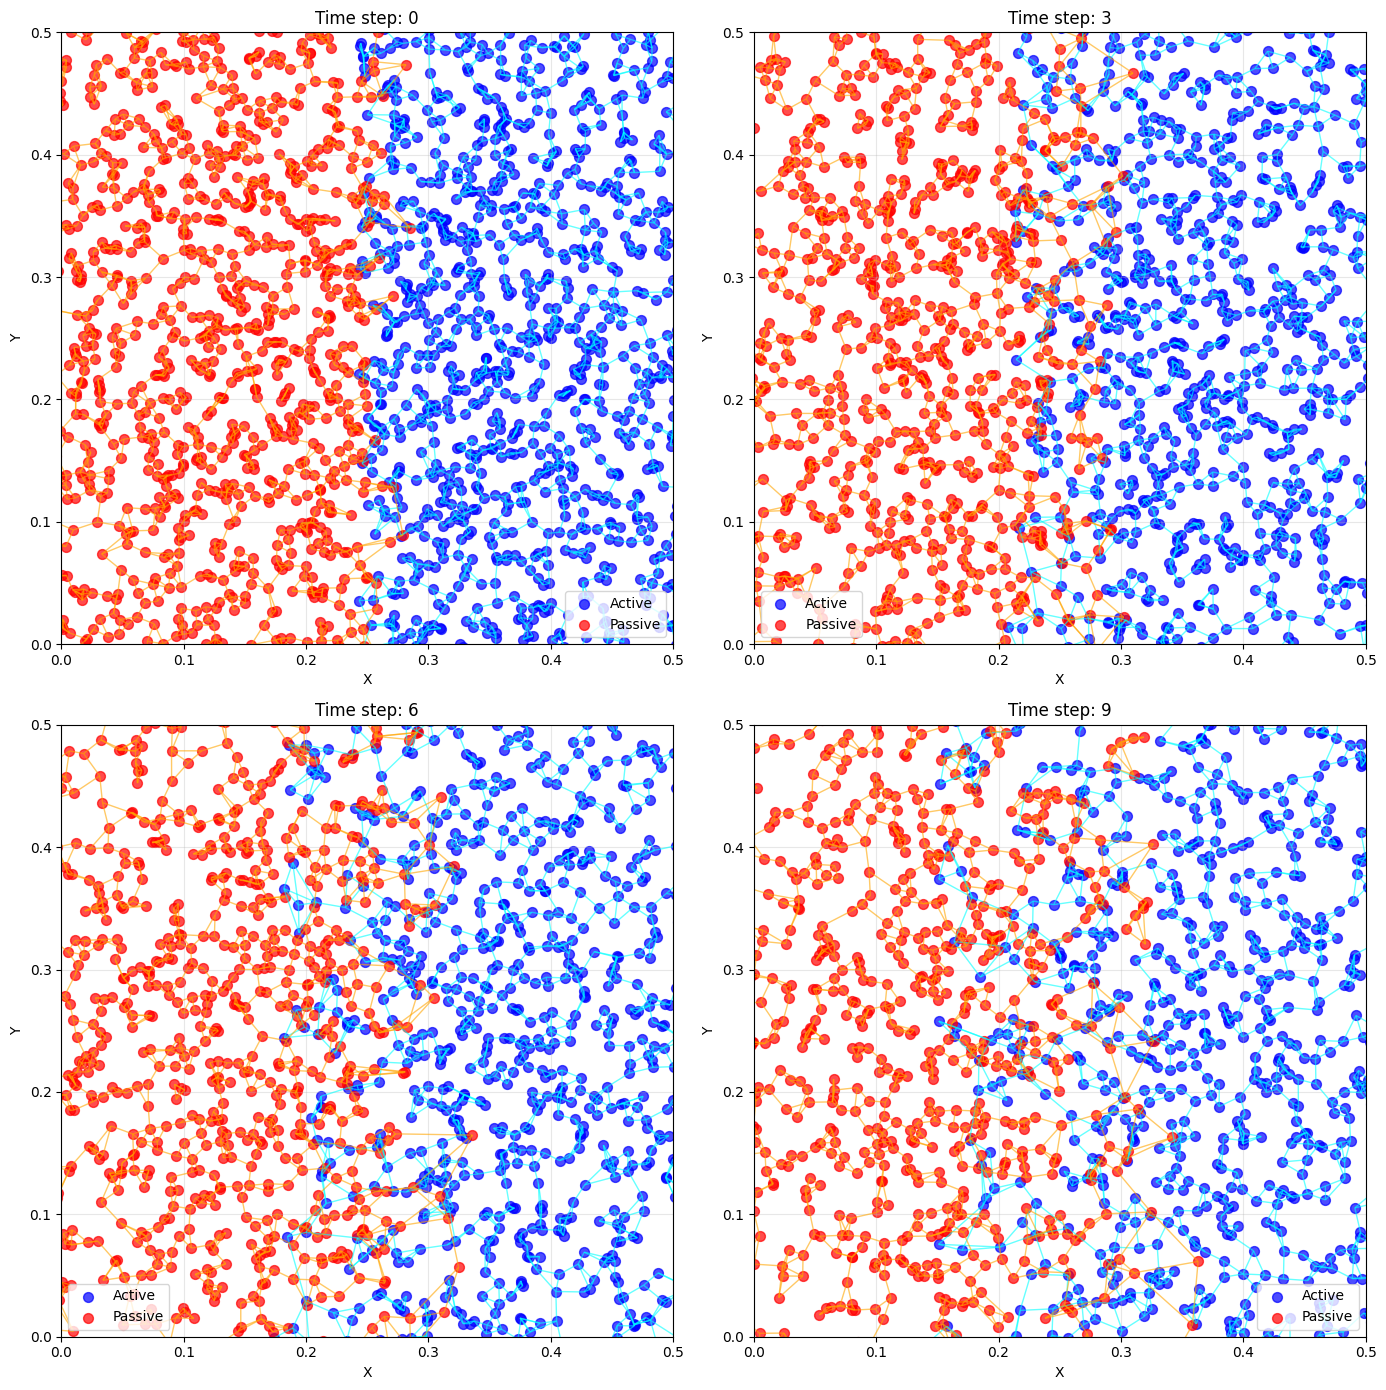

In [113]:
# number of nearest neighbors to connect
k_nn = 3  

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
frames = [0, n_steps//3, 2*n_steps//3, n_steps-1]

def knn_segments(positions, k):
    positions = np.asarray(positions)
    n = positions.shape[0]
    if n <= 1 or k <= 0:
        return []

    diffs = positions[:, None, :] - positions[None, :, :]
    dists = np.sqrt((diffs**2).sum(axis=2))
    np.fill_diagonal(dists, np.inf)
    neighbors = np.argsort(dists, axis=1)[:, :min(k, n-1)]
    edges = set()
    for i in range(n):
        for j in neighbors[i]:
            a, b = (i, j) if i < j else (j, i)
            edges.add((a, b))
    segments = [[positions[a], positions[b]] for (a, b) in edges]
    return segments

for idx, (ax, frame) in enumerate(zip(axes.flat, frames)):
    # Active particles
    active_pos = np.array(active_positions_history[frame])
    if active_pos.size > 0:
        ax.scatter(active_pos[:, 0], active_pos[:, 1], s=50, alpha=0.7, c='blue', label='Active')
        if active_pos.shape[0] > 1:
            segments = knn_segments(active_pos, k_nn)
            if segments:
                lc = LineCollection(segments, colors='cyan', linewidths=1, alpha=0.6)
                ax.add_collection(lc)

    # Passive particles
    passive_pos = np.array(passive_positions_history[frame])
    if passive_pos.size > 0:
        ax.scatter(passive_pos[:, 0], passive_pos[:, 1], s=50, alpha=0.7, c='red', label='Passive')
        if passive_pos.shape[0] > 1:
            segments_p = knn_segments(passive_pos, k_nn)
            if segments_p:
                lc2 = LineCollection(segments_p, colors='orange', linewidths=1, alpha=0.6)
                ax.add_collection(lc2)

    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_aspect('equal')
    ax.set_title(f'Time step: {frame}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()